# __House Prices Regression__

__Importing necessary libraries__

In [1]:
# Usual utilities
import os
import random
import pandas as pd
import numpy as np
import scipy.stats as stat
from scipy.special import boxcox1p
import statsmodels.api as sm
import warnings

# Graphic libraries
import seaborn as sns
import matplotlib.pyplot as plt

# Machine learning libraries
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV, ElasticNetCV, BayesianRidge, LassoLarsIC, ElasticNet
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor, ExtraTreesRegressor, RandomForestRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from mlxtend.regressor import StackingCVRegressor
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split

warnings.filterwarnings('ignore')

__Importing and checking data files__

In [2]:
train = pd.read_csv('train.csv', sep=',')
test = pd.read_csv('test.csv', sep=',')

display(train.head())
display(test.head())

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


__The 'Id' column is necessary for the submission file but not for the machine learning process, so we save it and remove it from the dataframes__

In [3]:
test_ID = test.Id
train.drop('Id', axis = 1, inplace = True)
test.drop('Id', axis = 1, inplace = True)

## Outliers

__The existence of outliers is mentionned in several kernels and discussions__ <br>Let's check for the variables most correlated to sale price first

In [4]:
train.corr()['SalePrice'].sort_values(ascending = False)[1:4]

OverallQual    0.790982
GrLivArea      0.708624
GarageCars     0.640409
Name: SalePrice, dtype: float64

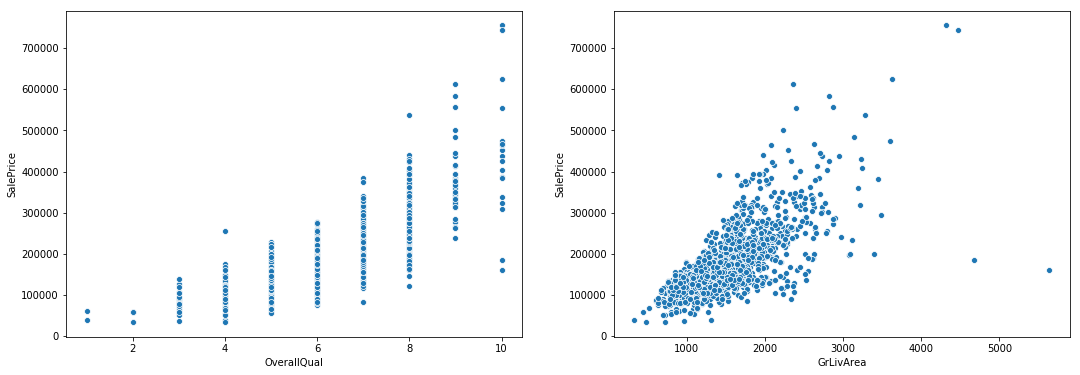

In [5]:
fig, ax = plt.subplots(ncols=2, figsize = (18,6))
sns.scatterplot('OverallQual', 'SalePrice', data=train, ax = ax[0])
sns.scatterplot('GrLivArea', 'SalePrice', data=train, ax = ax[1]);

We can see some data points displaying a huge living area and sold for very high or very low price. <br>These may be outliers, so we will remove them.

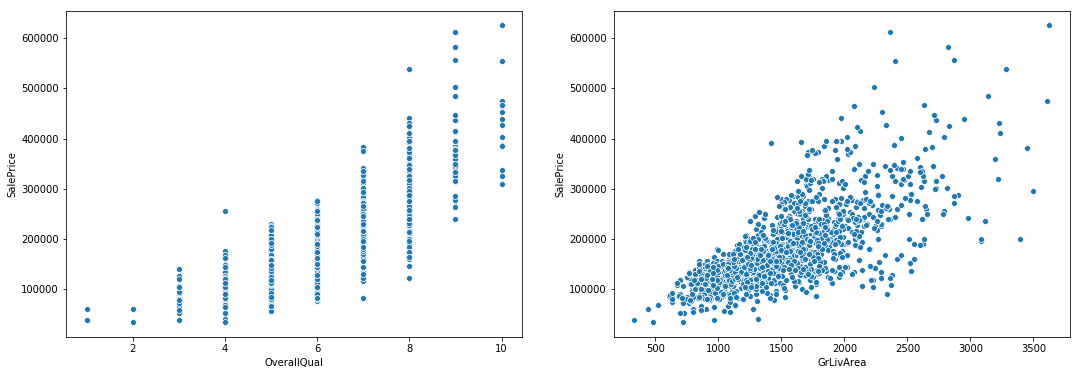

In [6]:
train.drop(train[train.GrLivArea > 4000].index, inplace = True)
fig, ax = plt.subplots(ncols=2, figsize = (18,6))
sns.scatterplot('OverallQual', 'SalePrice', data=train, ax = ax[0])
sns.scatterplot('GrLivArea', 'SalePrice', data=train, ax = ax[1]);

## Target Variable

We need to predict the 'SalePrice' variable

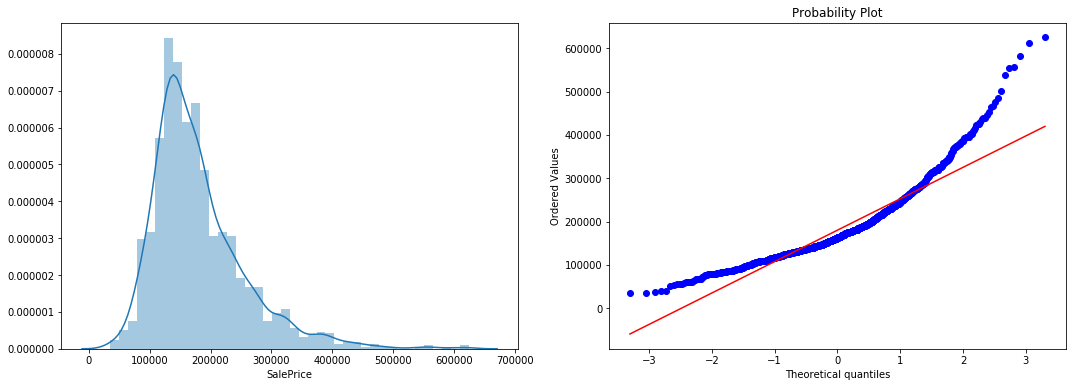

In [7]:
fig, axes = plt.subplots(ncols=2,figsize=(18,6))
sns.distplot(train.SalePrice,ax=axes[0])
res = stat.probplot(train.SalePrice,plot=plt)

'SalePrice' seems to follow some sort of logarythmic distribution. As regression alogorythms are better at predicting normally distibuted values, we want to transform this target variable.

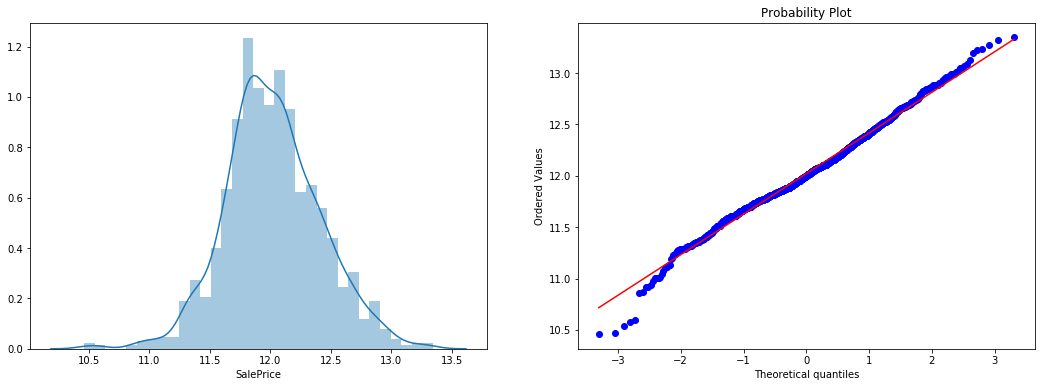

In [8]:
logSalePrice = np.log1p(train.SalePrice)

fig, axes = plt.subplots(ncols=2,figsize=(18,6))
sns.distplot(logSalePrice,ax=axes[0])
res = stat.probplot(logSalePrice,plot=plt)

The data now seems more normally distibuted

In [9]:
ytrain = logSalePrice
ytrain.reset_index(drop = True)
train.drop('SalePrice', axis = 1, inplace = True)

## Data processing

In [10]:
merged = pd.concat([train,test],axis=0).reset_index(drop = True)

### Missing values

First, let's see which columns contain missing values

In [11]:
missing_data = merged.isna().sum()[merged.isna().sum() != 0]
missing_data.index

Index(['MSZoning', 'LotFrontage', 'Alley', 'Utilities', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Electrical', 'BsmtFullBath',
       'BsmtHalfBath', 'KitchenQual', 'Functional', 'FireplaceQu',
       'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea',
       'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType'],
      dtype='object')

__The documentation provides useful insight into the meaning of NA values for the different columns__ <br>
In some cases, it means the variable has the typical value

In [12]:
merged.fillna({'Functional' : 'Typ',
                'Electrical' : 'SBrkr',
                'KitchenQual' : 'TA',
                'Utilities' : 'AllPub'}, inplace = True)

For many others, it means the feature is actually absent

In [13]:
merged.fillna({'GarageType' : 'None',
                'GarageFinish' : 'None',
                'GarageQual' : 'None',
                'GarageCond' : 'None',
                'GarageYrBlt' : 0,
                'GarageArea' : 0,
                'GarageCars': 0,
               
                'BsmtQual' : 'None',
                'BsmtCond' : 'None',
                'BsmtExposure' : 'None',
                'BsmtFinType1' : 'None',
                'BsmtFinType2' : 'None',
                'BsmtFinSF1' : 0,
                'BsmtFinSF2' : 0,
                'BsmtFullBath' : 0,
                'BsmtHalfBath' : 0,
                'BsmtUnfSF' : 0,
                'TotalBsmtSF' : 0,
               
                'MasVnrType' : 'None',
                'MasVnrArea' : 0,
               
                'FireplaceQu' : 'None',
                'Fence' : 'None',
                'Alley' : 'None',
                'PoolQC' : 'None',
                'MiscFeature' : 'None'}, inplace = True)

For some others, we must fill missing datapoints with the most common value

In [14]:
merged.fillna({'Exterior1st' : merged['Exterior1st'].mode()[0],
              'Exterior2nd': merged['Exterior2nd'].mode()[0],
              'SaleType' : merged['SaleType'].mode()[0]}, inplace = True)

This leaves two columns to complete : <br>- For 'MSZoning', we take the most common value among houses in the same MSSubClass group
    <br>- For 'LotFrontage', we assume that houses in the same neighborhood are likely to have similar designs, so we take the median value among houses in that group
    

In [15]:
merged['MSZoning'] = merged.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))

In [16]:
merged['LotFrontage'] = merged.groupby(by='Neighborhood')['LotFrontage'].transform(lambda x : x.fillna(x.median()))

Next, before going further into processing, we must check whether any column was wrognfully detected as numerical data

In [17]:
merged['MSSubClass'] = merged['MSSubClass'].apply(str)
merged['MoSold'] = merged['MoSold'].apply(str)
merged['YrSold'] = merged['YrSold'].apply(str)

__Regression algorythms function best with normally distributed features__ <br> Let's check whether numerical features are skewed

In [18]:
numerical_cols = merged.dtypes[merged.dtypes != 'object'].index

skewness = np.abs(merged[numerical_cols].skew()).sort_values(ascending = False)
skewed_features = skewness[skewness > 0.5].index
display(skewed_features)

Index(['MiscVal', 'PoolArea', 'LotArea', 'LowQualFinSF', '3SsnPorch',
       'KitchenAbvGr', 'BsmtFinSF2', 'EnclosedPorch', 'ScreenPorch',
       'BsmtHalfBath', 'GarageYrBlt', 'MasVnrArea', 'OpenPorchSF',
       'WoodDeckSF', '1stFlrSF', 'LotFrontage', 'GrLivArea', 'BsmtFinSF1',
       'BsmtUnfSF', '2ndFlrSF', 'TotRmsAbvGrd', 'Fireplaces', 'HalfBath',
       'TotalBsmtSF', 'BsmtFullBath', 'YearBuilt', 'OverallCond'],
      dtype='object')

We can try to make them normal via a BoxCox power transformation

In [19]:
for col in skewed_features:
    merged[col] = boxcox1p(merged[col],stat.boxcox_normmax(merged[col] + 1))

We can also create new features based on existing ones

In [20]:
merged['TotalSF'] = merged['1stFlrSF'] + merged['2ndFlrSF'] + merged['TotalBsmtSF']

merged['TotalFinished'] = merged['BsmtFinSF1'] + merged['BsmtFinSF2']\
                            + merged['1stFlrSF'] + merged['2ndFlrSF']

merged['YrBltAndRemod']= merged['YearBuilt']+ merged['YearRemodAdd']

merged['Total_Bathrooms'] = merged['FullBath'] + (0.5 * merged['HalfBath'])\
                            + merged['BsmtFullBath'] + (0.5 * merged['BsmtHalfBath'])
    
merged['Total_porch_sf'] = merged['OpenPorchSF'] + merged['3SsnPorch']\
                            + merged['EnclosedPorch'] + merged['ScreenPorch']\
                            + merged['WoodDeckSF']

merged['pool'] = merged['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
merged['2ndfloor'] = merged['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
merged['garage'] = merged['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
merged['basement'] = merged['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
merged['fireplace'] = merged['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

Inversely, we can delete some features which display very few data points with original values, and are thus unlikely to contribute to machine learnign

In [21]:
display(merged.Utilities.value_counts())
display(merged.PoolQC.value_counts())
display(merged.Street.value_counts())

AllPub    2914
NoSeWa       1
Name: Utilities, dtype: int64

None    2907
Gd         3
Ex         3
Fa         2
Name: PoolQC, dtype: int64

Pave    2903
Grvl      12
Name: Street, dtype: int64

In [22]:
merged.drop(['Utilities', 'PoolQC','Street'], axis = 1, inplace = True)

Last, before going into machine learning, we want to encode categorical variables into dummy variables

In [23]:
merged = pd.get_dummies(merged)

In [24]:
df_train = merged[:len(train)]
df_test = merged[len(train):]

Dummy encoding created numerous new features, some of which may be nearly monotonous. We can also remove them:

In [25]:
MonoValue = []
for column in df_train.columns:
    proportion = (df_train[column].value_counts().iloc[0] / len(df_train))
    if (proportion >= .9995):
        MonoValue.append(column)
        
MonoValue.append('MSZoning_C (all)')

In [26]:
df_train.drop(MonoValue, axis = 1, inplace = True)
df_test.drop(MonoValue, axis = 1, inplace = True)

Last, some kernels mention additional outliers. After testing, it seems removing them from the dataset improves performance.

In [27]:
outliers = [30, 88, 462, 631, 1322]
df_train = df_train.drop(df_train.index[outliers])
ytrain = ytrain.drop(ytrain.index[outliers])
df_train.reset_index(drop = True, inplace = True)
ytrain.reset_index(drop= True, inplace = True)

## Machine Learning

Most regressors function better when the different features are scaled to a comparable range. Fortunately, we can use a scaler object for this transformation

In [28]:
scaler = RobustScaler().fit(df_train)

Xtrain = scaler.transform(df_train)
Xtest = scaler.transform(df_test)

For each model, we can search for the best possible parametres.<br>
First we define a cross-validation strategy :

In [29]:
kf = KFold(n_splits= 10, shuffle= True, random_state= 33)

Then we use GridSearch to assess the best parametres

In [30]:
lasso_params = {'alpha' : [.0001,.001,.01,.1],
               'max_iter' : [10000]}
lasso = GridSearchCV(Lasso(), param_grid=lasso_params, cv = kf)
lasso.fit(Xtrain,ytrain)
display(lasso.best_estimator_)

Lasso(alpha=0.0001, copy_X=True, fit_intercept=True, max_iter=10000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

We also need to calculate the score for this estimator:

In [31]:
def gridScore(grid):
    rmsle = np.sqrt(-cross_val_score(grid.best_estimator_,
                                     Xtrain, ytrain,
                                     scoring= 'neg_mean_squared_error', cv = kf))
    print('RMSLE: %.4f, Stdev: %.4f' % (rmsle.mean(), rmsle.std()))

gridScore(lasso)

RMSLE: 0.1038, Stdev: 0.0109


After testing around, we obtain the best parametres for estimators:

In [32]:
Bridge = Ridge(alpha=20.8, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)
# RMSLE: 0.1034, Stdev: 0.0116


Bkridge = KernelRidge(alpha=0.11, coef0=0, degree=2, gamma=None, kernel='linear',
      kernel_params=None)
# RMSLE: 0.1186, Stdev: 0.0120



Bbridge = BayesianRidge(alpha_1=0.009, alpha_2=1, compute_score=False, copy_X=True,
       fit_intercept=True, lambda_1=1, lambda_2=0.001, n_iter=300,
       normalize=False, tol=0.001, verbose=False)
# RMSLE: 0.1036, Stdev: 0.0117


Blasso = Lasso(alpha=0.0001, copy_X=True, fit_intercept=True, max_iter=10000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)
# RMSLE: 0.1038, Stdev: 0.0109


Belastic = ElasticNet(alpha=0.012, copy_X=True, fit_intercept=True, l1_ratio=0.04,
      max_iter=5000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)
# RMSLE: 0.1033, Stdev: 0.0109


Bsvr = SVR(C=2, cache_size=200, coef0=0.0, degree=2, epsilon=0.001, gamma=0.002,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False) 
# RMSLE: 0.1072, Stdev: 0.0110

Bxgb = XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.37, gamma=0,
       importance_type='gain', learning_rate=0.11, max_delta_step=0,
       max_depth=4, min_child_weight=13, missing=None, n_estimators=200,
       n_jobs=1, nthread=None, objective='reg:squarederror',
       random_state=0, reg_alpha=0, reg_lambda=0.5, scale_pos_weight=1,
       seed=None, silent=None, subsample=1, verbosity=1)
# RMSLE: 0.1094, Stdev: 0.0074


Blgb = LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.08, max_depth=4,
       min_child_samples=15, min_child_weight=0, min_split_gain=0.0,
       n_estimators=400, n_jobs=-1, num_leaves=20, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.01, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

# RMSLE: 0.1154, Stdev: 0.0100

Now to improve precision, we can just make an estimator that averages the predictions of all different estimators:

In [33]:
class Blender(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
        [clone(x) for x in models]
        
    def fit(self, X, y, cv = None):
        self.models_ = [clone(x) for x in self.models]
        for model in self.models_ : 
            model.fit(X, y)
            
        return self
            
    def predict(self, X):
        pred = np.column_stack([model.predict(X) for model in self.models_])
        return pred.mean(axis=1)
    
    def new_features(self, X):
        return(np.column_stack([model.predict(X) for model in self.models_]))
    
def blenderScore(blender, X, y):
    kfc = KFold(n_splits= 10 , shuffle = True, random_state= 11).get_n_splits(X)
    sc = np.sqrt( -cross_val_score(blender, X, y, scoring = 'neg_mean_squared_error', cv = kfc) )
    print('RMSLE: %.4f, Stdev: %.4f' % (np.mean(sc), sc.std()))

In [34]:
blend = Blender([Bridge,Bkridge,Bbridge,Bsvr,Bxgb,Blgb,Blasso])
blend.fit(Xtrain,ytrain)
blenderScore(blend, Xtrain,ytrain)

RMSLE: 0.1015, Stdev: 0.0121


This is an improvement over the single predictors. Let's create a submission file

In [35]:
blendpred = np.exp(blend.predict(Xtest))

In [36]:
Answer = pd.DataFrame({'Id': test_ID, 'SalePrice' : blendpred})

In [37]:
Answer.to_csv('submission.csv', sep = ',', index = False)